In [11]:
#importando as dependencias necessarias
import pandas as pd
import json, csv, glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr
import itertools
import time, datetime, os

In [ ]:
#json nao esta mais sendo utilizado
"""formatando o arquivo de logger para ser compativel com o pandas
#obs: o arquivo de logger sera sobreescrito (podendo nao ser necesssario executar essa celula para determinado arquivo)
dic = {'ID_smartwatch':[], 'dateTime':[], 'battery':[], 'fileSize':[], 'pressure':[], 'lux':[], 'heartRate':[],
         'ecg':[], 'ppg':[], 'saturation':[], 'accelerometerZ':[], 'accelerometerX':[],
         'accelerometerY':[], 'gyroscopeZ':[], 'gyroscopeX':[], 'gyroscopeY':[]}

for filename in os.listdir("loggers"):
    print(filename)
    with open('loggers/'+filename, 'r') as file:
        d = file.read()
        f = json.loads(d)
        for key in f:
            dic[key] = dic[key] + list(f[key][0][1:-1].split(', '))
        
dic['ID_smartwatch'] = dic['ID_smartwatch'][0]
with open('data/logger.json', 'w') as file:
    file.write(json.dumps(dic))

with open('data/loggerECG.json', 'r+') as file:
    dic = file.read()
    f = json.loads(dic)
    for key in f:
        f[key] = list(f[key][0][1:-1].split(', '))

    for key in f:
        d = {}
        for i in range(len(f[key])):
            d[i] = f[key][i]
        f[key] = d
    file.seek(0)
    file.write(json.dumps(f))
    file.truncate()
"""

In [2]:
#para um unico arquivo.bin
with open('loggers/coletasJuntas.bin', 'r') as file:
    f = csv.reader(file)
    header = next(f)
    newHeader = [i.strip() for i in header[0:-1]]
    idSmart = header[-1][11:]
    print(newHeader, idSmart)

    with open('data/log.csv', 'w') as file:
        w = csv.writer(file)
        w.writerow(newHeader)
        for row in f:
            w.writerow(row)

['dateTime', 'battery', 'fileSize', 'sleepiness', 'pressure', 'lux', 'heartRate', 'ppgGreen', 'ppgRed', 'ppgIR', 'saturation', 'accelerometerZ', 'accelerometerX', 'accelerometerY', 'gyroscopeZ', 'gyroscopeX', 'gyroscopeY'] 7ab504da804297cb


In [22]:
#para multiplos arquivos.bin
filenames = []
i = 0

for filename in os.listdir("loggers"):
    filenames.append(filename)
    
    with open('loggers/'+filename, 'r') as file:
        f = csv.reader(file)
        header = next(f)
        if not i:
            idSmart = header[-1][11:]
            header = [j.strip() for j in header[0:-1]] 
            print(header, idSmart)
            
        if not i:
            with open('data/log2.csv', 'w') as new_file:
                w = csv.writer(new_file)
                w.writerow(header)
                for row in f:
                    w.writerow(row)
        else:
            with open('data/log2.csv', 'a') as new_file:
                w = csv.writer(new_file)
                for row in f:
                    w.writerow(row)
    i +=1

['dateTime', 'battery', 'fileSize', 'sleepiness', 'pressure', 'lux', 'heartRate', 'ppgGreen', 'ppgRed', 'ppgIR', 'saturation', 'accelerometerZ', 'accelerometerX', 'accelerometerY', 'gyroscopeZ', 'gyroscopeX', 'gyroscopeY'] 7ab504da804297cb


In [11]:
#definicao de variaveis
items = ['battery', 'fileSize', 'pressure', 'lux', 'heartRate',
         'ecg', 'ppg', 'saturation', 'accelerometerZ', 'accelerometerX',
         'accelerometerY', 'gyroscopeZ', 'gyroscopeX', 'gyroscopeY']
units = {'battery': 'bateria (%)',
             'fileSize': 'armazenamento (MB)',
             'pressure': 'pressao (hPa)',
             'lux': 'luminosidade (lux)',
             'heartRate': 'taxa de batimentos (bpm)',
             'ecg': 'ecg cru (mV)',
             'ppgGreen': 'ppg cru (mV)',
             'ppgIR': 'ppg cru (mV)',
             'ppgRed': 'ppg cru (mV)',
             'saturation': 'oxigenacao crua (mV)',
             'accelerometerZ': 'aceleracao (m/s²)',
             'accelerometerX': 'aceleracao (m/s²)',
             'accelerometerY': 'aceleracao (m/s²)',
             'gyroscopeZ': 'giroscopio (rad/s)',
             'gyroscopeX': 'giroscopio (rad/s)',
             'gyroscopeY': 'giroscopio (rad/s)',
             'sleepiness': 'nivel de sono'}

In [ ]:
#json nao esta mais sendo utilizado
"""
#Processamento dos dados para arquivos json
df = pd.read_json('data/logger.json')
#removendo o id do smartwatch do dataframe
df.drop(['ID_smartwatch'], axis=1, inplace=True)
df.head()
#print(df)
"""

In [24]:
#Processamento dos dados caso arquivo seja em csv
df = pd.read_csv('data/log.csv')
df.head()

,dateTime,battery,fileSize,sleepiness,pressure,lux,heartRate,ppgGreen,ppgRed,ppgIR,saturation,accelerometerZ,accelerometerX,accelerometerY,gyroscopeZ,gyroscopeX,gyroscopeY
0,2022-03-28T22:46:31-03:00,100.0,0.000333,0,921.37450,0.0,0.0,2115139.0,6290679.0,6554062.0,84.89149,-2.348712,3.306392,8.449138,0.053756,-0.085521,-0.109956
1,2022-03-28T22:46:32-03:00,100.0,0.000492,0,921.35425,0.0,0.0,2285827.0,6339629.0,6544423.0,85.00039,-2.477999,3.186682,9.042900,0.017104,-0.042761,0.001222
2,2022-03-28T22:46:33-03:00,100.0,0.000654,0,921.38430,0.0,0.0,2495719.0,6369232.0,6556569.0,84.99994,-2.348712,3.409343,8.980651,-0.014661,0.039095,-0.034208
3,2022-03-28T22:46:34-03:00,100.0,0.000815,0,921.36890,0.0,0.0,2589617.0,6366988.0,6550969.0,84.99997,-2.236184,1.338359,9.270349,-0.047647,0.028100,-0.003665
4,2022-03-28T22:46:37-03:00,100.0,0.000979,0,921.35720,36.0,0.0,2438508.0,6397196.0,6559814.0,84.99999,-4.800375,-5.796362,5.789180,0.477697,-0.306654,-0.195477


In [33]:
#visao geral dos dados (quantidade, media, desvio padrao, minimo, q1, mediana, q3 e maximo)
print(df.sleepiness.value_counts())
df.describe()

2    11679
0     8818
1     5102
Name: sleepiness, dtype: int64


,battery,fileSize,sleepiness,pressure,lux,heartRate,ppgGreen,ppgRed,ppgIR,saturation,accelerometerZ,accelerometerX,accelerometerY,gyroscopeZ,gyroscopeX,gyroscopeY
count,25599.000000,25599.000000,25599.000000,25599.000000,25599.000000,25599.000000,2.559900e+04,2.559900e+04,2.559900e+04,25599.000000,25599.000000,25599.000000,25599.000000,25599.000000,25599.000000,25599.000000
mean,53.758897,0.932108,1.111762,958.225798,1.111293,69.923146,1.846963e+06,5.816276e+06,6.027862e+06,88.647769,0.615273,-1.814121,5.148495,-0.002771,-0.000200,-0.000038
std,28.396053,0.729135,0.887826,49.362761,6.377853,12.512617,4.531897e+05,4.678981e+05,4.068138e+05,5.144245,4.152476,4.631276,5.404665,0.386758,0.261962,0.293546
min,2.000000,0.000216,0.000000,918.913600,0.000000,52.000000,-4.300000e+02,4.075070e+05,4.815940e+05,84.000000,-16.223110,-19.390640,-15.229517,-7.221649,-5.431814,-7.004181
25%,30.000000,0.336272,0.000000,920.177005,0.000000,63.000000,1.537134e+06,5.396296e+06,5.661601e+06,85.000000,-2.322376,-3.622427,1.525106,-0.003665,-0.003665,-0.002443
50%,54.000000,0.672160,1.000000,920.800800,0.000000,68.000000,1.949232e+06,5.934467e+06,6.094718e+06,85.000010,0.622492,-2.760515,7.910442,0.000000,0.000000,0.000000
75%,78.000000,1.521379,2.000000,1021.713870,0.000000,72.000000,2.172996e+06,6.176944e+06,6.350020e+06,94.000000,4.697424,-0.790087,9.205706,0.003665,0.003665,0.002443
max,100.000000,2.513082,2.000000,1023.536870,196.000000,156.000000,4.194014e+06,8.387100e+06,8.736712e+06,100.000000,12.227188,15.071500,19.311630,9.360899,10.775663,7.112915


In [6]:
#checando a existencia de valores nulos/faltantes
#df.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25599 entries, 0 to 25598
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dateTime        25599 non-null  object 
 1   battery         25599 non-null  float64
 2   fileSize        25599 non-null  float64
 3   sleepiness      25599 non-null  int64  
 4   pressure        25599 non-null  float64
 5   lux             25599 non-null  float64
 6   heartRate       25599 non-null  float64
 7   ppgGreen        25599 non-null  float64
 8   ppgRed          25599 non-null  float64
 9   ppgIR           25599 non-null  float64
 10  saturation      25599 non-null  float64
 11  accelerometerZ  25599 non-null  float64
 12  accelerometerX  25599 non-null  float64
 13  accelerometerY  25599 non-null  float64
 14  gyroscopeZ      25599 non-null  float64
 15  gyroscopeX      25599 non-null  float64
 16  gyroscopeY      25599 non-null  float64
dtypes: float64(15), int64(1), objec

In [ ]:
#convertendo datetime para valor numerico
time = []
y, mo, d = map(int, str(df['dateTime'][0])[0:10].split('-'))
h,m,s = map(int, str(df['dateTime'][0])[11:19].split(':'))
startingTime = datetime.datetime(y, mo, d, h, m, s).timestamp()

for val in range(len(df.dateTime)):
    v = str(df.dateTime[val])
    y, mo, d = map(int, v[0:10].split('-'))
    h,m,s = map(int, v[11:19].split(':'))
    ts = datetime.datetime(y, mo, d, h, m, s).timestamp()
    ts = ts - startingTime
    time.append(ts)
    
df.drop('dateTime', axis = 1, inplace=True)
df['dateTime'] = time
df.head()

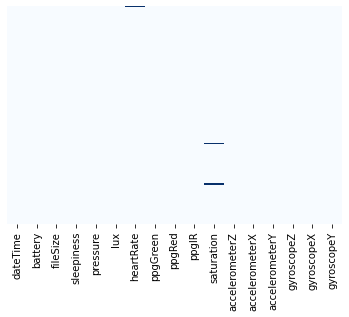

In [7]:
#substituindo leituras erroneas por NaN
df.ppgGreen.replace(0, np.nan, inplace=True)
df.ppgRed.replace(0, np.nan, inplace=True)
df.heartRate.replace(0, np.nan, inplace=True)
df.ppgIR.replace(0, np.nan, inplace=True)
df.saturation.replace(0, np.nan, inplace=True)
hm = sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'Blues')
figure = hm.get_figure()
figure.savefig('graphs/missing.png', bbox_inches='tight', dpi=800)

In [8]:
#substituindo os valores faltantes pela media da coluna (caso nao existam nao e necessario executar essa celula)
#obs: apenas valido para valores numericos
num_col = ['heartRate', 'ppgRed', 'ppgGreen', 'ppgIR', 'saturation'] # lista com as colunas que possuem valores faltantes
print(df.isna().sum())
for col in num_col:
    df[col]=pd.to_numeric(df[col])
    df[col].fillna(df[col].mean(), inplace=True)

dateTime            0
battery             0
fileSize            0
sleepiness          0
pressure            0
lux                 0
heartRate          57
ppgGreen            2
ppgRed              0
ppgIR               0
saturation        382
accelerometerZ      0
accelerometerX      0
accelerometerY      0
gyroscopeZ          0
gyroscopeX          0
gyroscopeY          0
dtype: int64


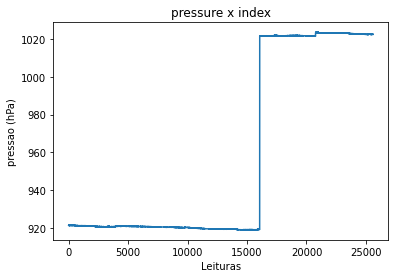

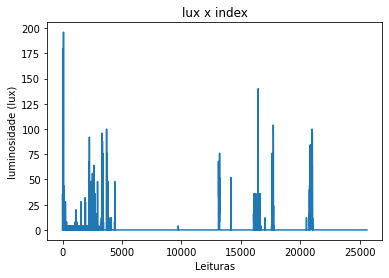

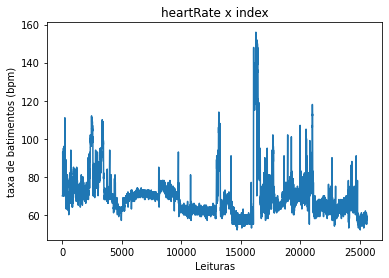

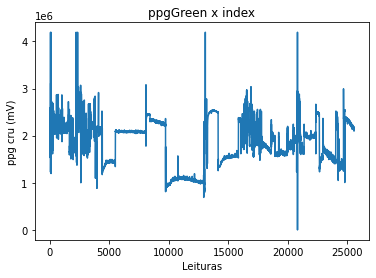

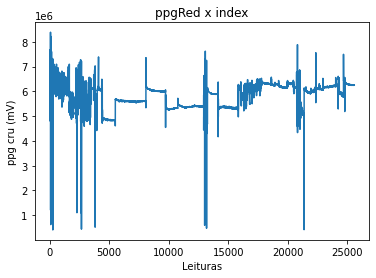

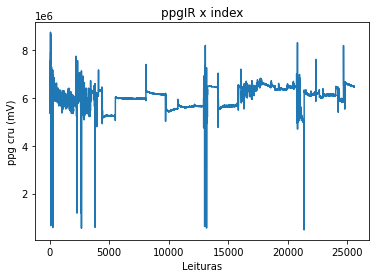

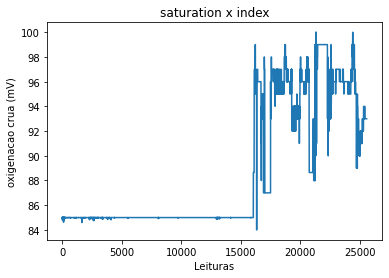

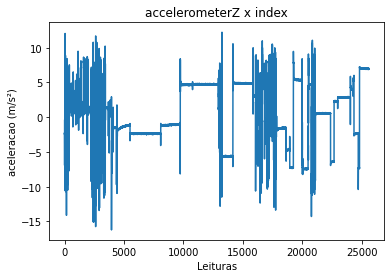

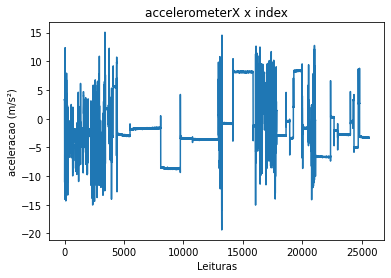

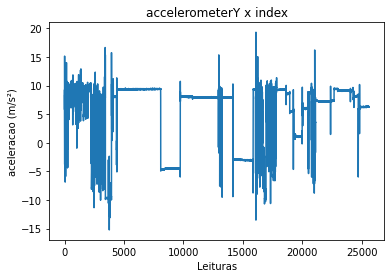

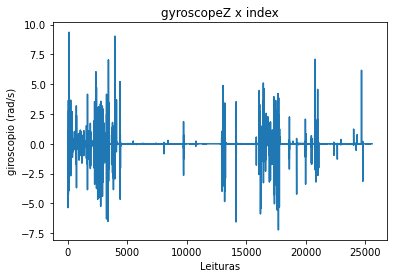

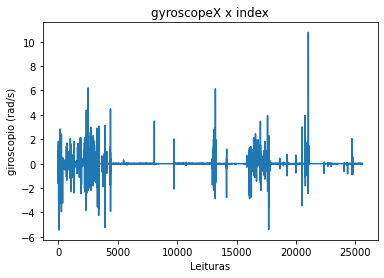

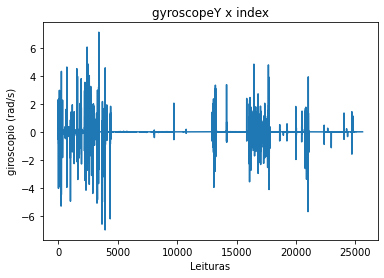

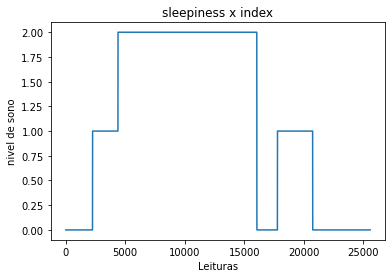

In [40]:
#visualizando as leituras de cada variavel
items = ['pressure', 'lux', 'heartRate', 'ppgGreen', 'ppgRed', 'ppgIR', 'saturation', 'accelerometerZ', 'accelerometerX',
         'accelerometerY', 'gyroscopeZ', 'gyroscopeX', 'gyroscopeY', 'sleepiness']
for var in items:
    y = df[var]
    #x = range(5000)
    x = range(y.size)
    plt.figure()
    plt.title(f"{var} x index")
    plt.xlabel("Leituras")
    plt.ylabel(f"{units[var]}")
    plt.plot(x,y)
    plt.savefig(f'graphs/linePlot_{y.name}.png', bbox_inches='tight')

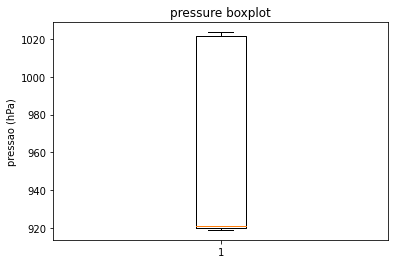

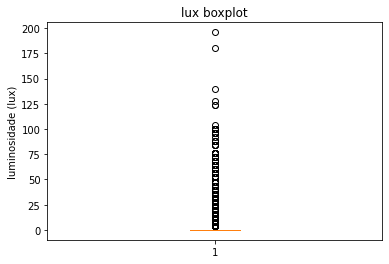

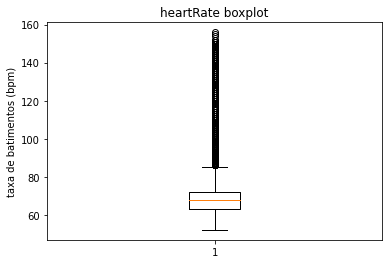

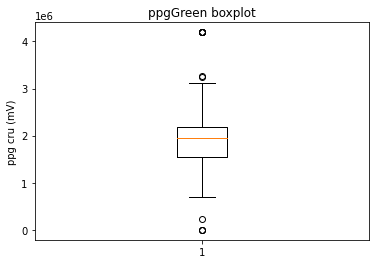

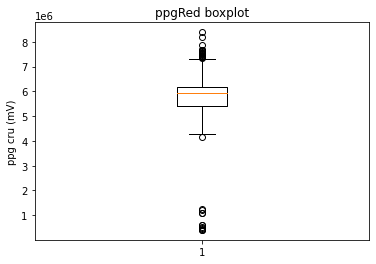

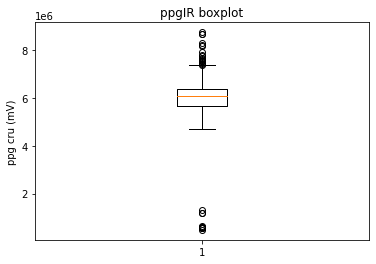

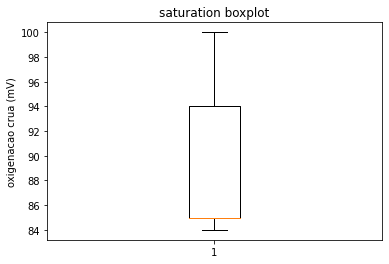

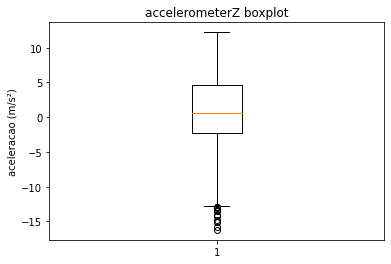

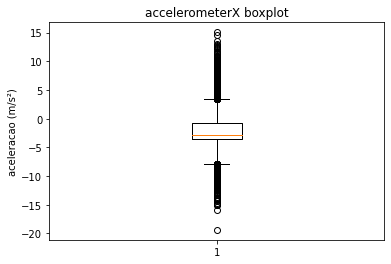

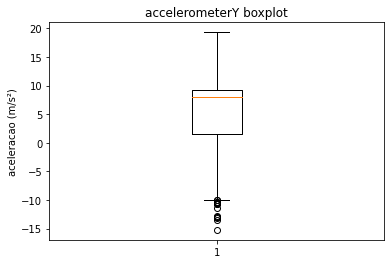

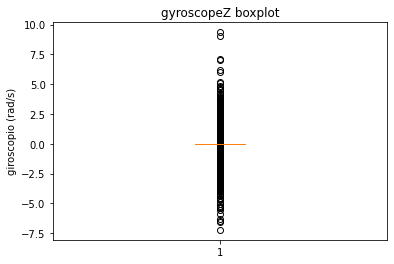

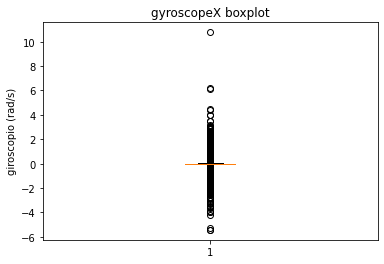

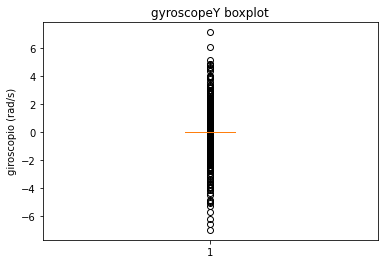

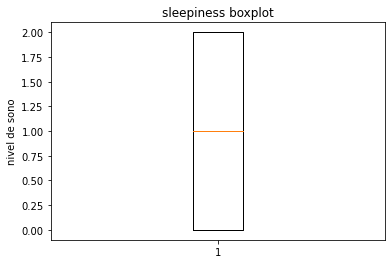

In [16]:
for var in items:
    y = list(df[var])
    plt.figure()
    plt.title(f"{var} boxplot")
    plt.ylabel(f"{units[var]}")
    plt.boxplot(y)
    plt.savefig(f'graphs/boxplot_{var}.png', bbox_inches='tight')

C:\Users\lapto\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lapto\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lapto\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

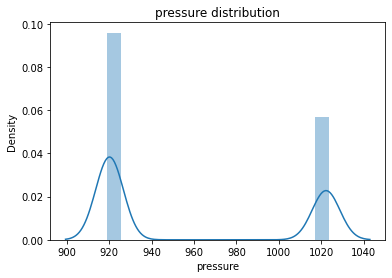

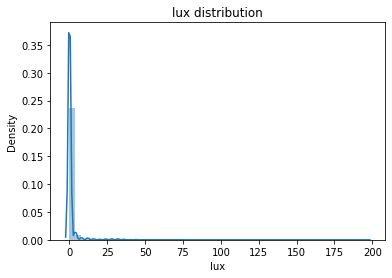

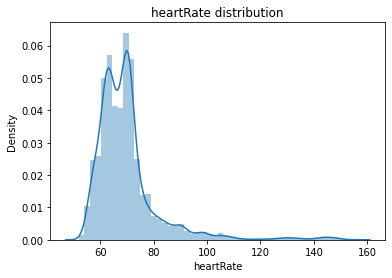

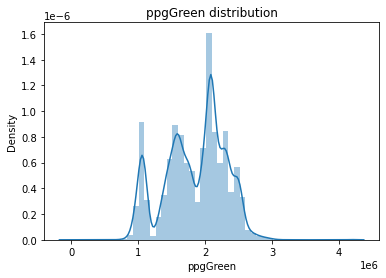

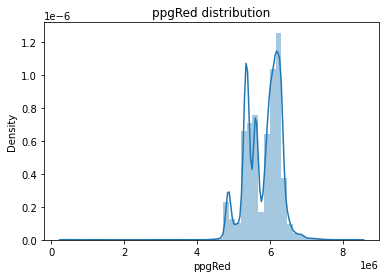

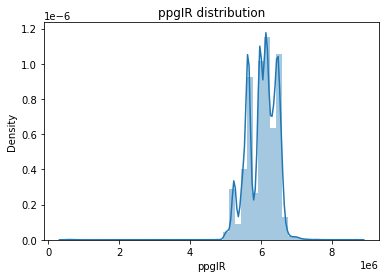

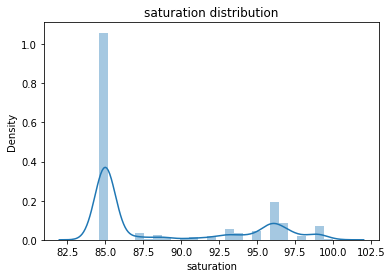

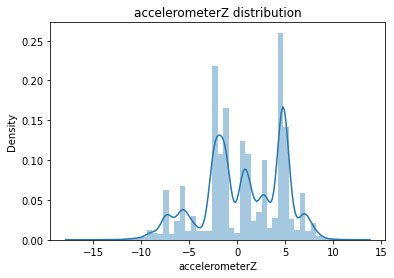

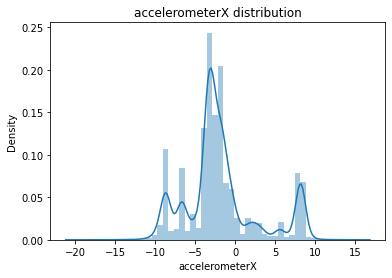

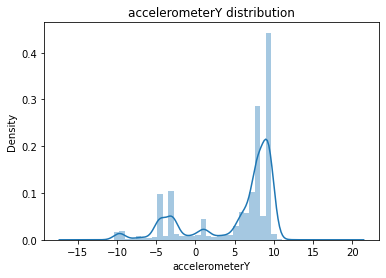

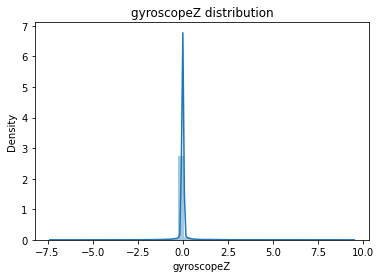

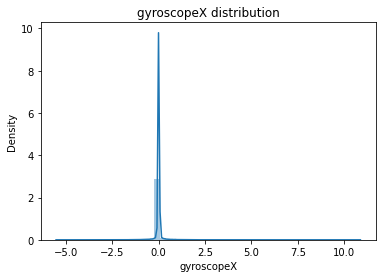

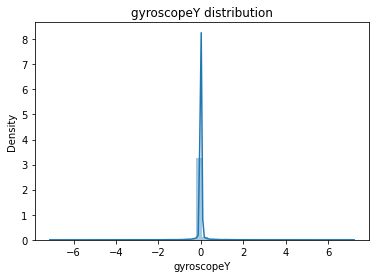

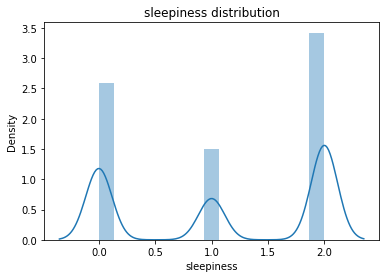

In [27]:
#visualizando a distribuicao dos dados
for var in items:
    #nCols = len(df.columns)
    #nRows = df.dateTime.size
    #plt.subplot(nRows+1,nCols,1)
    plt.figure()
    plt.title(f"{var} distribution")
    sns.distplot(df[var],kde=True)
    plt.savefig(f'graphs/distribution_{var}.png', bbox_inches='tight')

In [28]:
#calculando a covariancia entre variaveis
covariance = np.cov([df.ppgGreen, df.heartRate, df.lux])
print(covariance)

[[2.05380919e+11 1.74589730e+06 3.57489775e+05]
 [1.74589730e+06 1.56565596e+02 2.35701309e+01]
 [3.57489775e+05 2.35701309e+01 4.06770031e+01]]


In [29]:
#normalizando a covariancia para que se torne interpretavel(correlacao de pearson)
#metodo mais apropriado para distrubuicoes gaussianas
items = [df.ppgGreen, df.heartRate, df.lux]
for pair in itertools.combinations(items, 2):
    pCorr, _ = pearsonr(*pair)
    print(f"A correlacao de Pearson entre {pair[0].name} e {pair[1].name} eh: {pCorr:.3f}")

A correlacao de Pearson entre ppgGreen e heartRate eh: 0.308
A correlacao de Pearson entre ppgGreen e lux eh: 0.124
A correlacao de Pearson entre heartRate e lux eh: 0.295


In [30]:
#interpretando a covariancia pela correlacao de spearman (para distribuicoes nao gaussianas)
items = [df.ppgGreen, df.heartRate, df.lux]
for pair in itertools.combinations(items, 2):
    sCorr, _ = spearmanr(*pair)
    print(f"A correlacao de Spearman entre {pair[0].name} e {pair[1].name} eh: {sCorr:.3f}")

A correlacao de Spearman entre ppgGreen e heartRate eh: 0.426
A correlacao de Spearman entre ppgGreen e lux eh: 0.164
A correlacao de Spearman entre heartRate e lux eh: 0.334


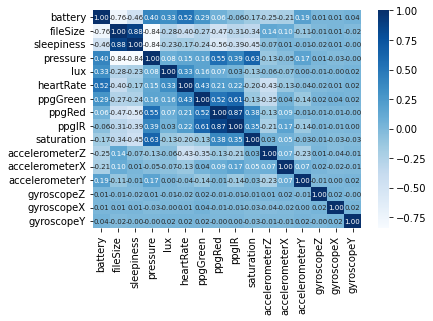

In [32]:
#ddf = df.copy()
#ddf.drop(['saturation'], axis=1, inplace=True)
cor = sns.heatmap(df.corr(method='spearman'),cmap='Blues',annot=True, fmt='.2f', annot_kws={"fontsize":7})
figure = cor.get_figure()    
figure.savefig('graphs/correlation_spearman.png', bbox_inches='tight', dpi=800)

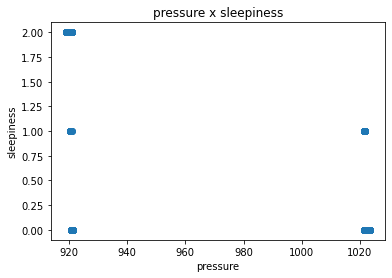

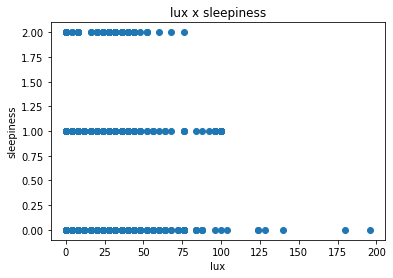

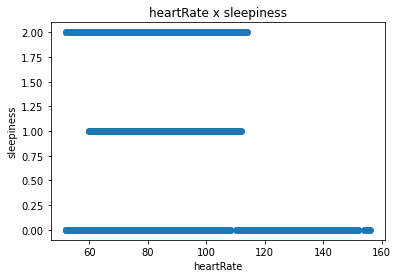

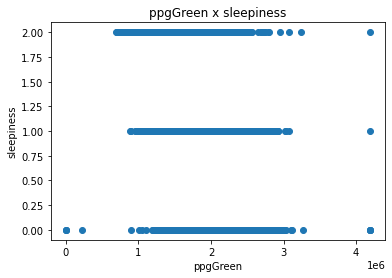

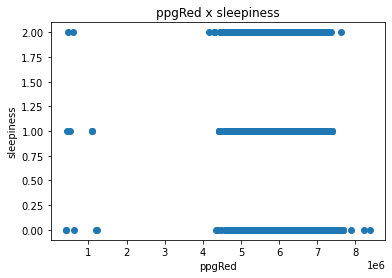

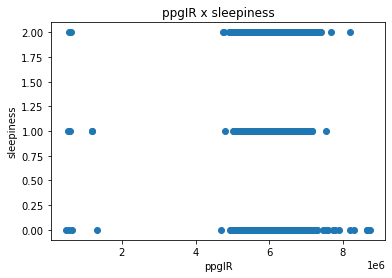

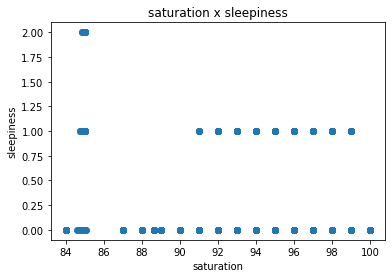

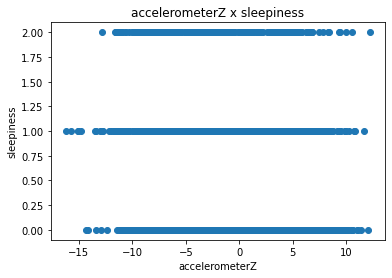

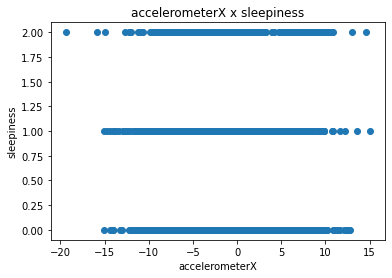

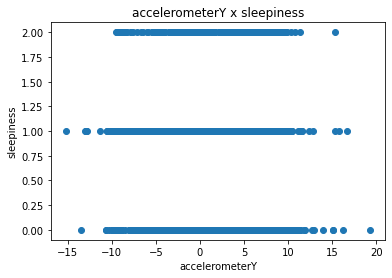

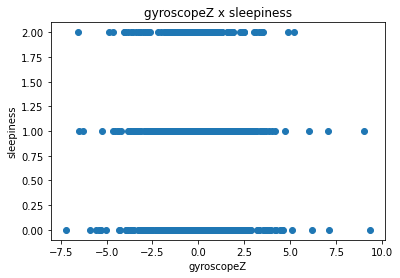

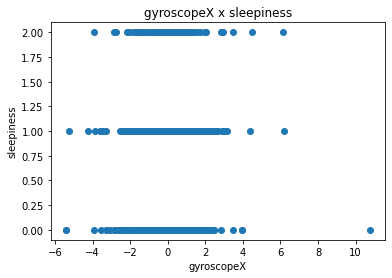

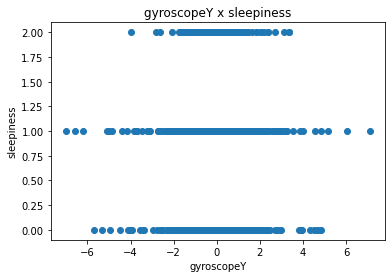

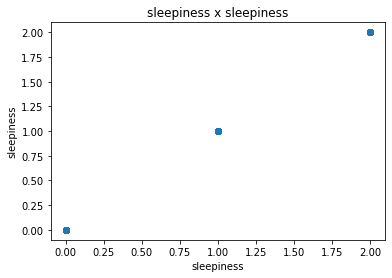

In [41]:
#comparacao de variavel com classificador por scatter
compare = ["saturation", "ppgRed", "pressure"]
for var in items:
    plt.figure()
    plt.title(f"{var} x sleepiness")
    plt.scatter(x=var, y='sleepiness', data=df)
    plt.xlabel(f'{var}')
    plt.ylabel('sleepiness')
    plt.savefig(f'graphs/scatter_{var}.png', bbox_inches='tight')

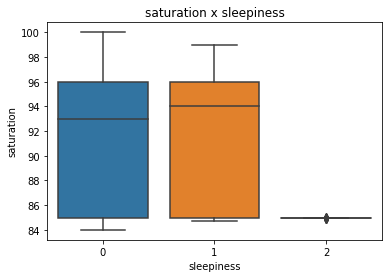

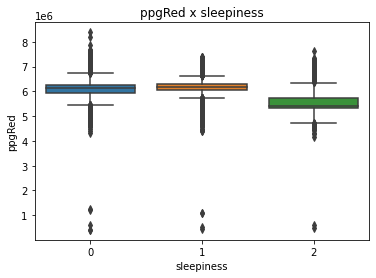

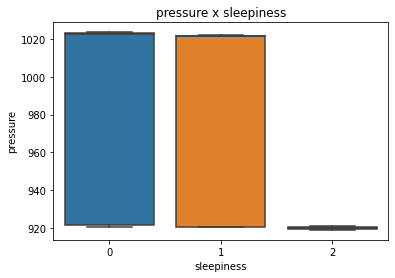

In [45]:
#comparacao de variavel com classificador por boxplot
compare = ["saturation", "ppgRed", "pressure"]
for var in compare:
    plt.figure()
    plt.title(f"{var} x sleepiness")
    sns.boxplot(x='sleepiness',y=var,data=df)
    plt.ylabel(f'{var}')
    plt.xlabel('sleepiness')
    plt.savefig(f'graphs/boxComparison_{var}.png', bbox_inches='tight')


In [ ]:
#normalizacao por maximum absolute scaling
def maxAbsoluteScale(df):
    scaledDf = df.copy()
    #Divide cada valor de uma coluna pelo valor maximo da mesma
    for column in scaledDf.columns:
        #as colunas de horario, tamanho de arquivo e bateria sao desconsideradas
        if column != 'dateTime' and column != 'size' and column != 'battery':
            scaledDf[column] = scaledDf[column]  / scaledDf[column].abs().max()
    #retorna os valores em uma escala de -1 a 1
    return scaledDf

In [ ]:
#normalizacao por min-max
def minMaxScale(df):
    scaledDf = df.copy()
    #aplicando a formula do min-max (x-min / range)
    for column in scaledDf.columns:
        #as colunas de horario, tamanho de arquivo e bateria sao desconsideradas
        if column != 'dateTime' and column != 'size' and column != 'battery':
            scaledDf[column] = (scaledDf[column] - scaledDf[column].min()) / (scaledDf[column].max() - scaledDf[column].min())
    #retorna os valores em uma escala entre 0 e 1
    return scaledDf

In [ ]:
#normalizacao por z-score (standardize)
def standardize(df):
    scaledDf = df.copy()
    #aplicando a formula do z-score (x-media / desvio padrao)
    for column in scaledDf.columns:
        #as colunas de horario, tamanho de arquivo e bateria sao desconsideradas
        if column != 'dateTime' and column != 'size' and column != 'battery':
            scaledDf[column] = (scaledDf[column] - scaledDf[column].mean()) / scaledDf[column].std()
    #retorna os valores com media = 0 e desvio padrao = 1
    return scaledDf

In [ ]:
#normalizacao por robust scaling (ideal para dados com muitos outliers)
def robustScaling(df):
    scaledDf = df.copy()
    #aplicando a formula do robust scaling (x-mediana/(q3-q2)*) *interquartille range
    for column in scaledDf.columns:
        #as colunas de horario, tamanho de arquivo e bateria sao desconsideradas
        if column != 'dateTime' and column != 'size' and column != 'battery':
            scaledDf[column] = (scaledDf[column] - scaledDf[column].median())  / (scaledDf[column].quantile(0.75) - scaledDf[column].quantile(0.25))
    return scaledDf

In [24]:
#calculando o numero de outliers
def outlierCount(df, var):
    try:
        q1= df[var].quantile(0.25)
        q3 = df[var].quantile(0.75)
        iqRange = q3 - q1
        maxVal = q3 + 1.5 * iqRange
        minVal = q1 - 1.5 * iqRange
        count = len(df[(df[var] < minVal)]) + len(df[(df[var] > maxVal)])
        return count, minVal, maxVal
    except:
        #print(f"{var} falhou")
        return "null", "null", "null"

for col in df.columns:
    a, b, c = outlierCount(df, col)
    print(f'{col}: {a},'.ljust(25) + f' |min = {b},'.ljust(35) + f' |max = {c}')

dateTime: null,           |min = null,                       |max = null
battery: 0,               |min = -42.0,                      |max = 150.0
fileSize: 0,              |min = -1.4413884250000002,        |max = 3.2990387350000003
sleepiness: 0,            |min = -3.0,                       |max = 5.0
pressure: 0,              |min = 767.8717075,                |max = 1174.0191675
lux: 1851,                |min = 0.0,                        |max = 0.0
heartRate: 1997,          |min = 49.5,                       |max = 85.5
ppgGreen: 12,             |min = 583342.25,                  |max = 3126788.25
ppgRed: 35,               |min = 4225322.0,                  |max = 7347918.0
ppgIR: 29,                |min = 4628973.25,                 |max = 7382647.25
saturation: 0,            |min = 71.5,                       |max = 107.5
accelerometerZ: 13,       |min = -12.85207475,               |max = 15.22712325
accelerometerX: 6046,     |min = -7.870938145,               |max = 3.45842437

In [ ]:
#tratando outliers
def removeOutliers(df, *args):
    newDf = df.copy()
    for var in args:
        count, minVal, maxVal = outlierCount(df, var)
        newDf = newDf[(newDf[var] > minVal) & (newDf[var] < maxVal)]
    return newDf
    
noOutliers = removeOutliers(df, 'heartRate')
print(outlierCount(noOutliers, 'heartRate'))

In [ ]:
maxAbsDf = maxAbsoluteScale(df)
minMaxDf = minMaxScale(df)
zScoreDf = standardize(df)
robustDf = robustScaling(df)

In [ ]:
y = list(noOutliers.heartRate)
plt.boxplot(y)

In [ ]:
y = df.heartRate
x = range(0, len(df.dateTime))
plt.plot(x,y)

In [ ]:
y = zScoreDf.heartRate
x = zScoreDf.dateTime
plt.plot(x,y)

In [ ]:
zScoreNoOut = standardize(noOutliers)
y = zScoreNoOut.ppgGreen
x = zScoreNoOut.dateTime
plt.plot(x,y)

In [ ]:
#checando a correlacao apos processamento
items = [zScoreNoOut.ecg, zScoreNoOut.heartRate, zScoreNoOut.lux]
for pair in itertools.combinations(items, 2):
    sCorr, _ = spearmanr(*pair)
    print(f"A correlacao de Spearman entre {pair[0].name} e {pair[1].name} eh: {sCorr:.3f}")